In [47]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['plant.csv', 'jtd.csv', 'invoice.csv', 'customer.csv', 'vehicles.csv']


In [48]:
pip install fuzzywuzzy

Note: you may need to restart the kernel to use updated packages.


In [49]:
# from google.colab import drive
# drive.mount('/content/drive')

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from google.colab import files
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [51]:
#import important libraries
from fuzzywuzzy import process
import re

In [52]:
path = "../input/"

# customer_df = pd.read_csv(path + 'customer.csv')
# invoice_df = pd.read_csv(path + 'invoice.csv')
# jtd_df = pd.read_csv(path + 'jtd.csv')
# plant_df = pd.read_csv(path + 'plant.csv')
# vehicles_df = pd.read_csv(path + 'vehicles.csv')

customer_df = pd.read_csv(path + 'customer.csv')
invoice_df = pd.read_csv(path + 'invoice.csv')
jtd_df = pd.read_csv(path + 'jtd.csv')
plant_df = pd.read_csv(path + 'plant.csv')
vehicles_df = pd.read_csv(path + 'vehicles.csv')

In [53]:
print(" invoice_df shape : ",invoice_df.shape)
print(" customer_df shape: ",customer_df.shape)
print(" plant_df shape   : ",plant_df.shape)
print(" vehicles_df shape: ",vehicles_df.shape)
print(" jtd_df shape     : ",jtd_df.shape)

 invoice_df shape :  (984741, 59)
 customer_df shape:  (555338, 10)
 plant_df shape   :  (438, 14)
 vehicles_df shape:  (588761, 5)
 jtd_df shape     :  (5619484, 10)


In [54]:
# 1. drop unwanted columns from all dataframes
def drop_col(dataset, col_to_drop):
    dataset.drop(col_to_drop, axis=1, inplace=True)
    return dataset

# 2. lowercase all the categorical columns
def lowercase(dataset):
    categorical_col = dataset.select_dtypes(exclude=['number']).columns
    for col in categorical_col:
        dataset[col] = dataset[col].map(lambda x: x if type(x)!=str else x.lower())
    return dataset

invoice_columns_to_drop  = ['Unnamed: 0', 'Amt Rcvd From Custom', 'Amt Rcvd From Ins Co','Area / Locality',
                            'CGST(14%)', 'CGST(2.5%)', 'CGST(6%)', 'CGST(9%)',
                            'IGST(12%)', 'IGST(18%)', 'IGST(28%)', 'IGST(5%)', 'Insurance Company',
                            'Outstanding Amt', 'SGST/UGST(14%)', 'SGST/UGST(2.5%)', 'SGST/UGST(6%)', 'SGST/UGST(9%)',
                            'Service Advisor Name', 'TDS amount', 'Total CGST', 'Total GST', 'Total IGST',
                            'Total SGST/UGST','Plant Name1','Recovrbl Exp']
customer_columns_to_drop = ['Unnamed: 0','Death date']
plant_columns_to_drop    = ['Unnamed: 0','Name 1','Factory calendar','Valuation Area',
                           'Customer no. - plant','PO Box','Postal Code','Name 2',
                           'Vendor number plant','House number and street']
jtd_columns_to_drop      = ['Unnamed: 0']
vehicles_columns_to_drop = ['Unnamed: 0','Product GUID']

dataframes = [invoice_df, customer_df, plant_df, jtd_df, vehicles_df]
dataframe_columns_to_drop = [invoice_columns_to_drop, customer_columns_to_drop, plant_columns_to_drop,
                             jtd_columns_to_drop, vehicles_columns_to_drop]

for i in range(len(dataframes)):
    dataframes[i] = drop_col(dataframes[i],dataframe_columns_to_drop[i])
    dataframes[i] = lowercase(dataframes[i])

In [55]:

# Preprocessing for dataset merge operation

# 1. Remove leading zeros from 'Customer No.' column
def remove_leading_zeros(dataset,cols):
    for col in cols:
          dataset[col] = dataset[col].astype(str).apply(lambda x: x.lstrip("0"))
    return dataset
invoice_df  = remove_leading_zeros(invoice_df,['Customer No.'])
customer_df = remove_leading_zeros(customer_df,['Customer No.'])


# 2. Rename columns to use them as key column for merge operation
def rename_columns(dataset, rename_cols_dict):
    dataset.rename(columns=rename_cols_dict, inplace=True)
    return dataset
dict_invoice_df = {'District':'State'}
dict_vehicles_df = {'Vehicle Model':'Make', 'License Plate Number':'Regn No'}

invoice_df  = rename_columns(invoice_df, dict_invoice_df)
vehicles_df = rename_columns(vehicles_df, dict_vehicles_df)


# 3. Replace values in key columns for merge operation
def replacement(dataset, col, dict_replacement, regex=False):
    dataset[col] = dataset[col].replace(dict_replacement, regex=regex )
    return dataset
make_replacements = {
                    'mahindra &  mahindra': 'mahindra',
                    'tata motors': 'tata',
                    'maruti suzuki': 'maruti',
                    'mercedes benz': 'mercedes-benz',
                    'porche': 'porsche',
                    'land rover' : 'rover',
                    'mitsubishi motors':'mitsubishi motor',
                    'premier\xa0automobiles': 'premierauto'
                    }
pattern_replacement = {'z_':''}
vehicles_df = replacement(vehicles_df, 'Make', pattern_replacement, regex=True)
vehicles_df = replacement(vehicles_df, 'Make', make_replacements)
invoice_df  = replacement(invoice_df, 'Make', make_replacements)

# 4. Drop rows where license plate number is less than 1 
mask = (vehicles_df['Regn No'].str.len() > 1)
vehicles_df = vehicles_df.loc[mask]

In [56]:
# Merge dataframes based on key
def merge_df(left_df, right_df, key):
    merge_df = pd.merge(left=left_df, right=right_df, how='left', on=key)
    return merge_df

invoice_customer_df = merge_df(left_df=invoice_df, right_df=customer_df,key=['Customer No.'])
invoice_customer_plant_df = merge_df(left_df=invoice_customer_df, right_df=plant_df,key=['Plant','State'])
invoice_customer_plant_vehicles_df = merge_df(left_df=invoice_customer_plant_df, right_df=vehicles_df,key=['Regn No','Make'])

master_df = invoice_customer_plant_vehicles_df

In [57]:
print(" invoice_df : ",invoice_df.shape)
print(" customer_df : ",customer_df.shape)
print(" invoice_customer_df : ",invoice_customer_df.shape)
print(" plant_df : ",plant_df.shape)
print(" invoice_customer_plant_df : ",invoice_customer_plant_df.shape)
print(" vehicles_df : ",vehicles_df.shape)
print(" invoice_customer_plant_vehicles_df  : ",invoice_customer_plant_vehicles_df.shape)
print(" master_df : ",master_df.shape)

 invoice_df :  (984741, 33)
 customer_df :  (555338, 8)
 invoice_customer_df :  (984741, 40)
 plant_df :  (438, 4)
 invoice_customer_plant_df :  (984741, 42)
 vehicles_df :  (586668, 3)
 invoice_customer_plant_vehicles_df  :  (989602, 43)
 master_df :  (989602, 43)


In [58]:
# create column 'Regn State' from 'Regn No'
url = 'https://kb.bullseyelocations.com/support/solutions/articles/5000695302-india-state-codes'
file = pd.read_html(url, header=0)

# 1. get the state abbrevation from site
states_df = file[0]
states_df.drop(['Alternate Abbreviation'], axis=1, inplace=True)
states_df['Abbreviation'] = states_df['Abbreviation'].str.lower()

# 2. Create abbrevation from Regn No
master_df['Abbreviation'] = master_df['Regn No'].astype(str).str[:2]
master_df = master_df[master_df['Abbreviation'].str.isalpha()]

# 3. merge dataframes to get the State Name 
master_df = merge_df(left_df=master_df, right_df=states_df,key=['Abbreviation'])

# rename State column
master_df = rename_columns(master_df, {'State Name':'Regn State'})

In [59]:
master_df[['Regn No', 'Regn State']].sample(5)

,Regn No,Regn State
729316,rj06ca9618,Rajasthan
129921,pb10eb4844,Punjab
838041,mh31dc2012,Maharashtra
607953,od162939,NaN
356475,pb65u6262,Punjab


In [60]:
# fill missing values for City
master_df['City'] = master_df['City'].fillna(master_df['CITY'])
master_df = drop_col(master_df,'CITY')

# Function to identify the number of missing values in every feature
def missing_datas(dataset):
    total = dataset.isnull().sum().sort_values(ascending=False)
    percent = ((dataset.isnull().sum())*100/dataset.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data
    
missing_data_master_df = missing_datas(master_df)
print("missing data for 'master_df': ")
print(missing_data_master_df[missing_data_master_df['Percent']>0.00])

missing_data_jtd_df = missing_datas(jtd_df)
print("missing data for 'jtd_df': ")
print(missing_data_jtd_df[missing_data_jtd_df['Percent']>0.00])

missing data for 'master_df': 
                      Total    Percent
Claim No.            983903  99.509483
Occupation           962203  97.314800
Cash /Cashless Type  961057  97.198896
Date of Birth        958283  96.918341
Marital Status       954694  96.555358
Gate Pass Date       942379  95.309850
Policy no.           920652  93.112436
Expiry Date          891342  90.148096
Technician Name      730608  73.891862
Total Value          689414  69.725604
ODN No.              689414  69.725604
Sales organization   276801  27.994959
Title                151855  15.358234
Regn State            36602   3.701835
Fuel Type             18386   1.859514
Data Origin            7621   0.770769
Partner Type           5487   0.554941
Business Partner       3508   0.354790
Model                  1640   0.165865
Regn No                  16   0.001618
Cust Type                 4   0.000405
City                      3   0.000303
missing data for 'jtd_df': 
                       Total    Percent
Labo

In [61]:
# Function to drop missing values
def drop_missing(dataset, missing, min_threshold, max_threshold):
    dataset = dataset.drop((missing[missing['Percent'] > max_threshold]).index,axis= 1)
    dataset = dataset.dropna(axis=0, subset=(missing[missing['Percent'] < min_threshold]).index)
    return dataset 

master_df  = drop_missing(master_df,missing_data_master_df,2,40)
jtd_df     = drop_missing(jtd_df,missing_data_jtd_df,2,40)

In [62]:
#recheck the missing values
new_missing_data = missing_datas(master_df)
print("missing data for 'master_df'")
print(new_missing_data[new_missing_data['Percent']>0.00])

new_missing_data = missing_datas(jtd_df)
print("missing data for 'jtd_df'")
print(new_missing_data[new_missing_data['Percent']>0.00])

missing data for 'master_df'
                     Total    Percent
Sales organization  257159  26.751115
Title               130498  13.575130
Regn State           36043   3.749394
missing data for 'jtd_df'
Empty DataFrame
Columns: [Total, Percent]
Index: []


In [63]:
#fill missing values with mode
def Fill_Missing_Values(dataset, cols):
    for col in cols:
        dataset[col].fillna(dataset[col].dropna().mode()[0], inplace = True)
    return dataset
  
master_df = Fill_Missing_Values(dataset=master_df,cols=['Sales organization','Title','Regn State'])

In [64]:
# combine Date & Time columns
def to_datetime(dataset, datetime_cols):
    for datetime in datetime_cols:
        dataset[datetime[0] + '-' + datetime[1]] = pd.to_datetime(dataset[datetime[0]]+ ' ' + dataset[datetime[1]])
    return dataset
datetime_cols = ['Invoice Date','Invoice Time','JobCard Date','JobCard Time']
master_df = to_datetime(master_df, [['Invoice Date','Invoice Time'],['JobCard Date','JobCard Time']])


#split datetime column
master_df['Year']  = master_df['Invoice Date-Invoice Time'].dt.year
master_df['Month'] = master_df['Invoice Date-Invoice Time'].dt.month


# add job duration column
def job_completion_time(dataset, start_datetime, end_datetime):
    dataset['Job_duration(in days)'] = (dataset[start_datetime] - dataset[end_datetime]) / np.timedelta64(1,'D')
    return dataset
master_df = job_completion_time(master_df, 'Invoice Date-Invoice Time', 'JobCard Date-JobCard Time')


# add total all costs to get 'Total Expenses'
def sum_cols(dataset, cols_to_sum, result_col):
    dataset[result_col] = 0
    for col in cols_to_sum:
        dataset[result_col] = dataset[result_col] + dataset[col]
    return dataset
cost_cols     = ['Misc Total','OSL Total','Parts Total','Total Amt Wtd Tax.']
master_df =  sum_cols(master_df, cost_cols, 'Total_Expense')


#remove dulicate column Date-Time columns
master_df = drop_col(master_df, datetime_cols)
master_df = drop_col(master_df, cost_cols)

# drop unique value columns
unique_cols = ['User ID','Regn No','Pin code','Invoice No','Job Card No','Abbreviation']
master_df = drop_col(master_df, unique_cols)

In [65]:
# map column description
def map_description(dataset,col, map_dict):
    dataset[col] = dataset[col].astype(str).map(map_dict)
    return dataset

data_origin_dict = { 'z001':'Camp-Outdoor','z002':'Camp-Workshop','z003':'Emailers',
                     'z004':'Fleet','z005':'Ref-Customer','z006':'Ref-Employee',
                     'z007':'Used Car Dealer','z008':'Just Dial/Other',
                     'z009':'Snapdeal/Web','z010':'Company website',
                     'z011':'Float activity','z012':'Petrol pump',
                     'z013':'Hoardings/ADVT','z014':'Insurance Co',
                     'z015':'Television AD','z016':'Newspaper AD',
                     'z017':'Newsppr leaflet','z018':'Sales Activity',
                     'z019':'Spotted outlet','z020':'M & M Employee',
                     'z021':'Outdoor Activty','z022':'Radio'
                  }

partner_type_dict = {'1.0':'Retail','2.0':'Corporate','3.0':'Fleet',
                     '4.0':'Employee','9001.0':'Insurance Company',
                     '9002.0':'Surveyor','9003.0':'Contact Person'
                    }

master_df = map_description(master_df,'Data Origin', data_origin_dict)
master_df = map_description(master_df,'Partner Type', partner_type_dict)

# change columns dtype

def modify_col_type(dataset, col, dtype):
    dataset[col] = dataset[col].astype(dtype)
    return dataset

master_df = modify_col_type(master_df, 'Fuel Type', int)

In [66]:
# Function to identify numeric features
def numeric_features(dataset):
    numeric_col = dataset.select_dtypes(include=['number']).columns
    return numeric_col

numeric_columns_master_df = numeric_features(master_df)
print("Numeric Features for master_df:")
print(numeric_columns_master_df)

numeric_columns_jtd_df = numeric_features(jtd_df)
print("Numeric Features for jtd_df:")
print(numeric_columns_jtd_df)

print("===="*30)

# Function to identify categorical features
def categorical_features(dataset):
    categorical_col = dataset.select_dtypes(exclude=['number']).columns
    return categorical_col

categorical_columns_master_df = categorical_features(master_df)
print("Categorical Features for master_df:")
print(categorical_columns_master_df)

categorical_columns_jtd_df = categorical_features(jtd_df)
print("categorical Features for jtd_df:")
print(categorical_columns_jtd_df)

Numeric Features for master_df:
Index(['KMs Reading', 'Labour Total', 'Title', 'Fuel Type', 'Year', 'Month',
       'Job_duration(in days)', 'Total_Expense'],
      dtype='object')
Numeric Features for jtd_df:
Index(['DBM Order', 'Order Item', 'Order Quantity', 'Net value'], dtype='object')
Categorical Features for master_df:
Index(['Cust Type', 'Customer No.', 'State', 'Gate Pass Time', 'Make', 'Model',
       'Order Type', 'Plant', 'Print Status', 'Business Partner',
       'Partner Type', 'Data Origin', 'City', 'Sales organization',
       'Regn State', 'Invoice Date-Invoice Time', 'JobCard Date-JobCard Time'],
      dtype='object')
categorical Features for jtd_df:
Index(['Material', 'Description', 'Item Category', 'Target quantity UoM'], dtype='object')


In [67]:
master_df.sample(5)

,Cust Type,Customer No.,State,Gate Pass Time,KMs Reading,Labour Total,Make,Model,Order Type,Plant,Print Status,Business Partner,Partner Type,Data Origin,Title,City,Sales organization,Fuel Type,Regn State,Invoice Date-Invoice Time,JobCard Date-JobCard Time,Year,Month,Job_duration(in days),Total_Expense
590568,retail,398976,karnataka,00:00:00,126545,250.01,mahindra,bolero,paid service,x483,no,410776,Retail,Ref-Customer,2.0,davangere,mfcd,2,Karnataka,2017-06-13 16:59:12,2017-06-13 12:16:01,2017,6,0.196655,540.39
875879,retail,60784,andhra pradesh,00:00:00,15490,550.10,hyundai,i10,paid service,bc05,no,64562,Retail,Camp-Outdoor,2.0,hyderabad,mfcd,1,Andhra Pradesh,2014-05-30 12:33:51,2014-05-29 12:23:37,2014,5,1.007106,3665.78
967825,retail,28457,maharashtra,00:00:00,94770,0.00,maruti,800,running repairs,bc03,no,30494,Retail,Outdoor Activty,2.0,nashik,mfcd,1,Maharashtra,2013-10-08 17:49:32,2013-10-07 17:26:06,2013,10,1.016273,0.00
600267,retail,367965,assam,00:00:00,22130,833.89,hyundai,eon,running repairs,x247,no,379725,Retail,Fleet,2.0,digboi,mfcd,1,Assam,2017-06-25 16:27:11,2017-06-25 16:05:47,2017,6,0.014861,1455.69
22162,retail,148565,tamil nadu,00:00:00,75926,1646.02,hyundai,santro,paid service,x066,no,156834,Retail,Ref-Employee,2.0,palani,mfcd,1,Tamil Nadu,2016-01-09 12:50:53,2016-01-08 12:22:27,2016,1,1.019745,10305.10


In [68]:
def display_unique_values(dataset, categirical_cols, info='count'):
    print("Unique values: ")  
    for col in categirical_cols:
        if(info == 'values'):
                print("{} : {}".format(col, dataset[col].unique()))
        elif(info == 'count'):
                print("{} : {}".format(col, len(dataset[col].unique())))
    return None

display_unique_values(master_df, categorical_columns_master_df, 'count')   
display_unique_values(master_df, categorical_columns_master_df, 'values')

Unique values: 
Cust Type : 5
Customer No. : 497629
State : 36
Gate Pass Time : 25156
Make : 28
Model : 254
Order Type : 9
Plant : 431
Print Status : 2
Business Partner : 497629
Partner Type : 7
Data Origin : 22
City : 8885
Sales organization : 5
Regn State : 34
Invoice Date-Invoice Time : 940078
JobCard Date-JobCard Time : 937863
Unique values: 
Cust Type : ['retail' 'mfcwl' 'fleets' 'corporate- m&m' 'corporate others']
Customer No. : ['17' '7' 'e22364' ... '39870' '39701' '39898']
State : ['maharashtra' 'andhra pradesh' 'tamil nadu' 'chandigarh' 'uttar pradesh'
 'gujarat' 'delhi' 'daman and diu' 'madhya pradesh' 'punjab'
 'himachal pradesh' 'nagaland' 'mizoram' 'kerala' 'karnataka'
 'dadra and nagar hav.' 'arunachal pradesh' 'puducherry' 'haryana'
 'telangana' 'rajasthan' 'chhattisgarh' 'uttarakhand' 'jammu and kashmir'
 'bihar' 'west bengal' 'jharkhand' 'sikkim' 'goa' 'assam' 'odisha'
 'andaman and nico.in.' 'megalaya' 'manipur' 'tripura' 'lakshadweep']
Gate Pass Time : ['00:00:00' 

Invoice Date-Invoice Time : ['2012-04-02T17:26:52.000000000' '2012-04-02T17:44:03.000000000'
 '2012-04-02T20:04:51.000000000' ... '2013-12-31T20:46:44.000000000'
 '2013-12-31T20:47:20.000000000' '2013-12-31T20:47:23.000000000']
JobCard Date-JobCard Time : ['2012-04-02T16:13:11.000000000' '2012-04-02T12:47:59.000000000'
 '2012-04-01T16:19:32.000000000' ... '2013-12-30T12:40:38.000000000'
 '2013-12-27T11:54:42.000000000' '2013-12-31T10:06:36.000000000']


**Some Common Functions**

In [69]:
def get_top_values(dataset,col,min_percentage):
    filtered_df = dataset[col].value_counts()
    filtered_df=filtered_df.reset_index()
    filtered_df[col] = (filtered_df[col]/sum(filtered_df[col]))*100
    filtered_df = filtered_df.sort_values(col)
    filtered_df = filtered_df[filtered_df[col]>min_percentage]
    top_values  = filtered_df['index'].tolist()
    top_values_df = dataset[dataset[col].isin(top_values)]
    return top_values_df, top_values

def plot_TimeSeries(dataset, time_col, cat_col, num_col):
    fig, ax = plt.subplots(figsize=(15,7))
    plt.title("'{}'wise '{}' in top '{}'".format(time_col, num_col, cat_col))
    dataset.groupby([time_col,cat_col])[num_col].sum().unstack().plot(ax=ax,marker='o')

1. **Problem Statement-** : 
Identifying the ownership pattern of cars throughout the
country. 
This also captures the problem wherein information regarding the
spending patterns can be identified.

**Univariate Analysis**

In [70]:
def count_plot(dataset,col,min_threshold=0.7, title=None):
        filtered_df = dataset[col].value_counts()
        filtered_df=filtered_df.reset_index()
        filtered_df[col] = (filtered_df[col]/sum(filtered_df[col]))*100
        filtered_df = filtered_df.sort_values(col)
        filtered_df = filtered_df[filtered_df[col]>min_threshold]
#         fig, ax = plt.subplots(figsize=(10,8))
        plt.bar(filtered_df['index'],filtered_df[col])
        plt.style.use('fivethirtyeight')
        if(title==None):
            plt.title('Count plot for "{}"'.format(col))
        plt.ylabel('Percentage')
        plt.xlabel(col)
        plt.xticks(rotation='vertical')
        plt.tight_layout()
        plt.show()

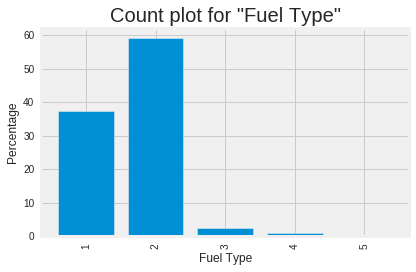

In [71]:
count_plot(master_df,'Fuel Type',0)

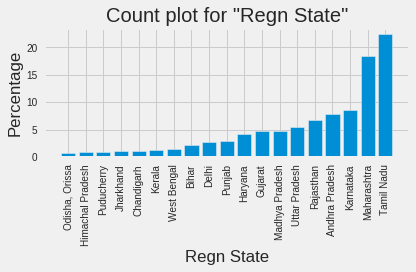

In [72]:
count_plot(master_df,'Regn State')

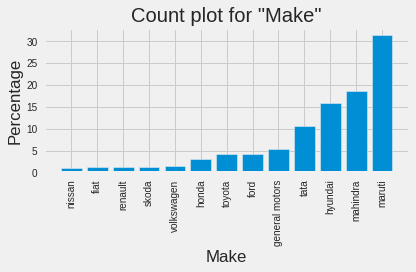

In [73]:
count_plot(master_df,'Make')

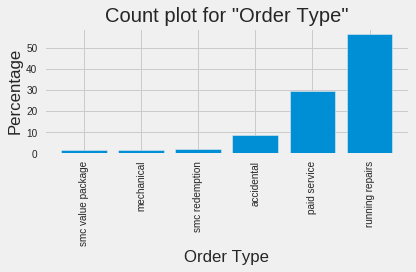

In [74]:
count_plot(master_df,'Order Type')

**Bivariate Analysis**

In [75]:
def count_hue_plot(dataset,x_col, hue_col, min_percentage,title=None):
    sns.set(style="darkgrid")
    fig, ax = plt.subplots(figsize=(20, 10))
    filtered_df1, filter_col_values1 = get_top_values(master_df, x_col, min_percentage)
    filtered_df, filter_col_values = get_top_values(filtered_df1, hue_col, min_percentage)
    sns.countplot(x=x_col, data=filtered_df, hue=hue_col)
    if(title==None):
        plt.title("'{}' wise distribution for '{}'".format(x_col,hue_col))
    plt.xticks(rotation='vertical')
    plt.show()

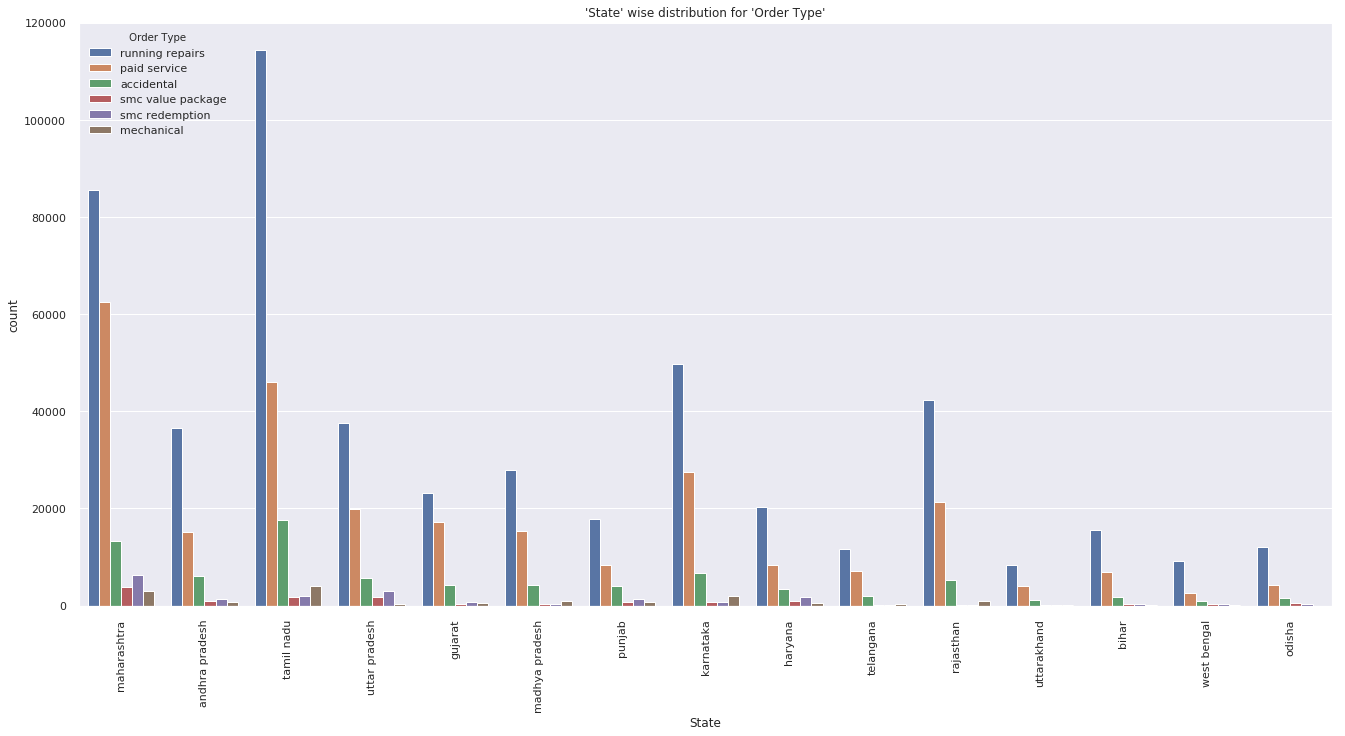

In [76]:
count_hue_plot(master_df,'State','Order Type', 1.0)

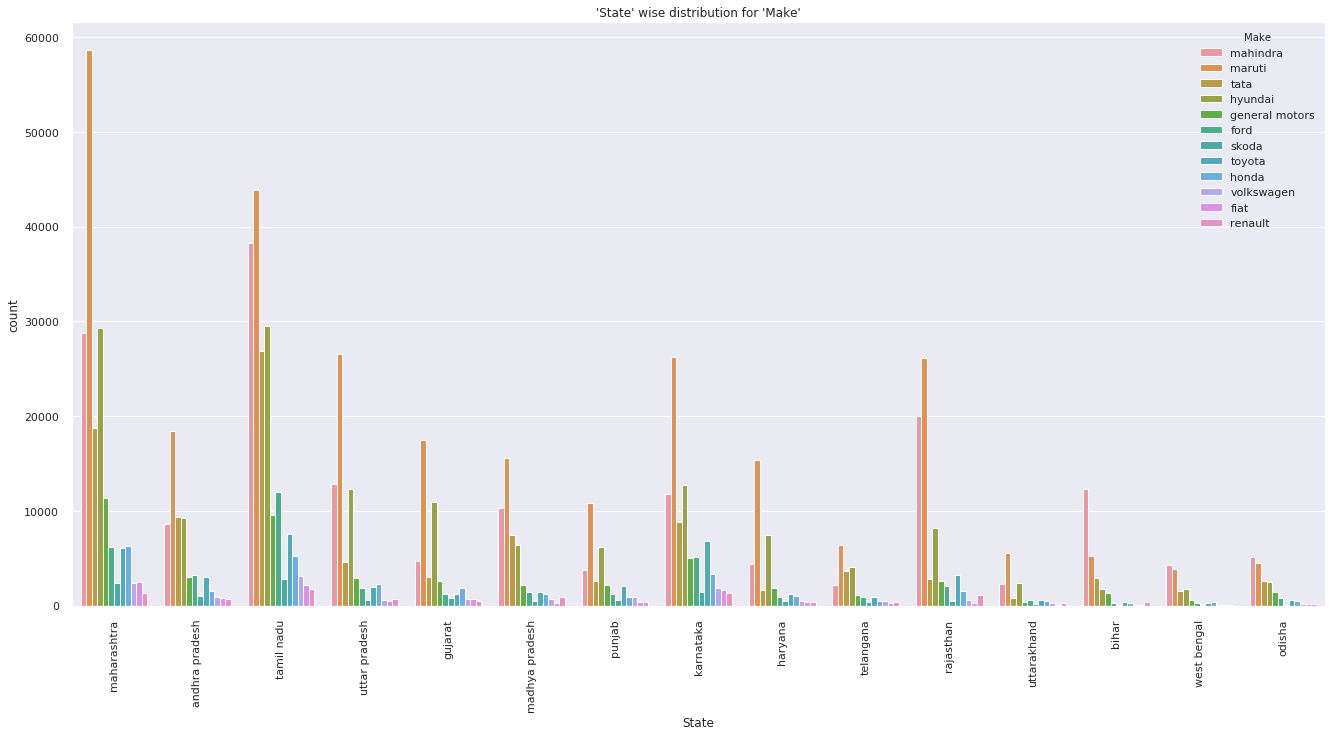

In [77]:
count_hue_plot(master_df,'State','Make', 1.0)

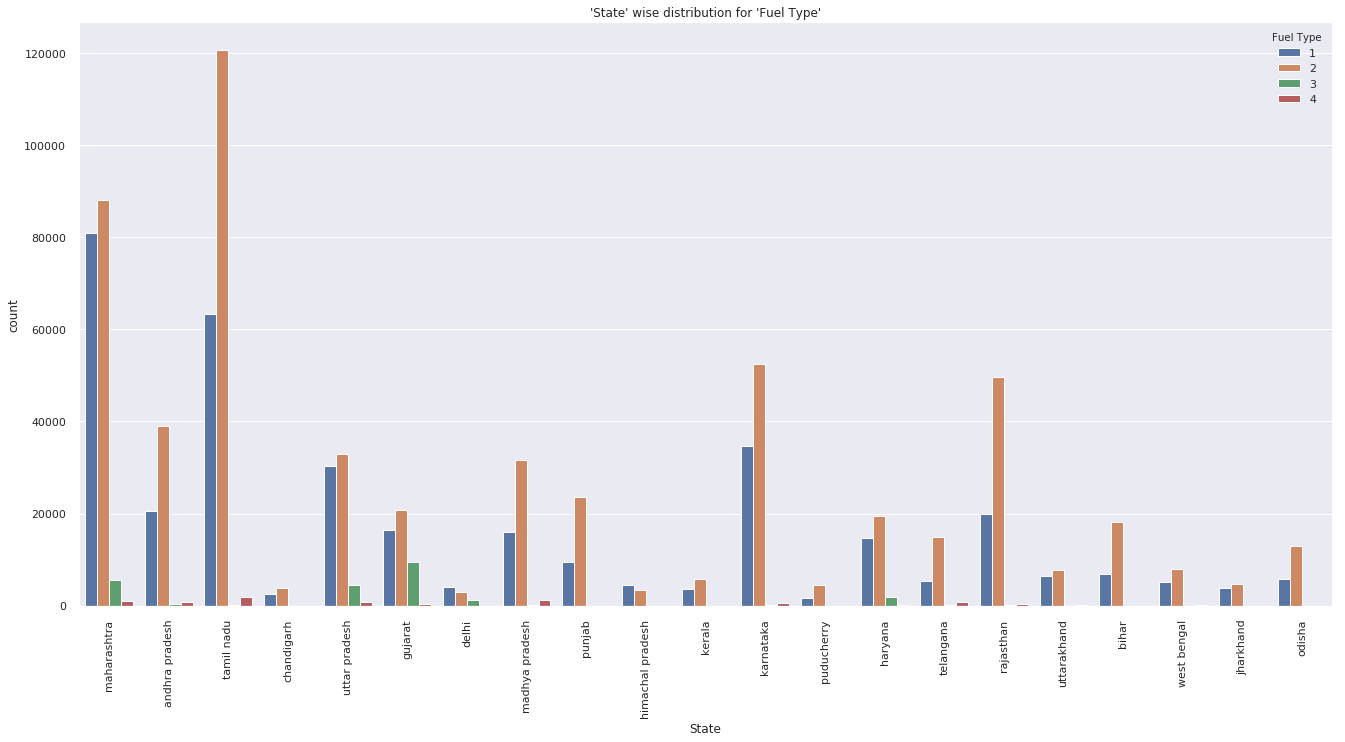

In [78]:
count_hue_plot(master_df,'State','Fuel Type', 0.6)

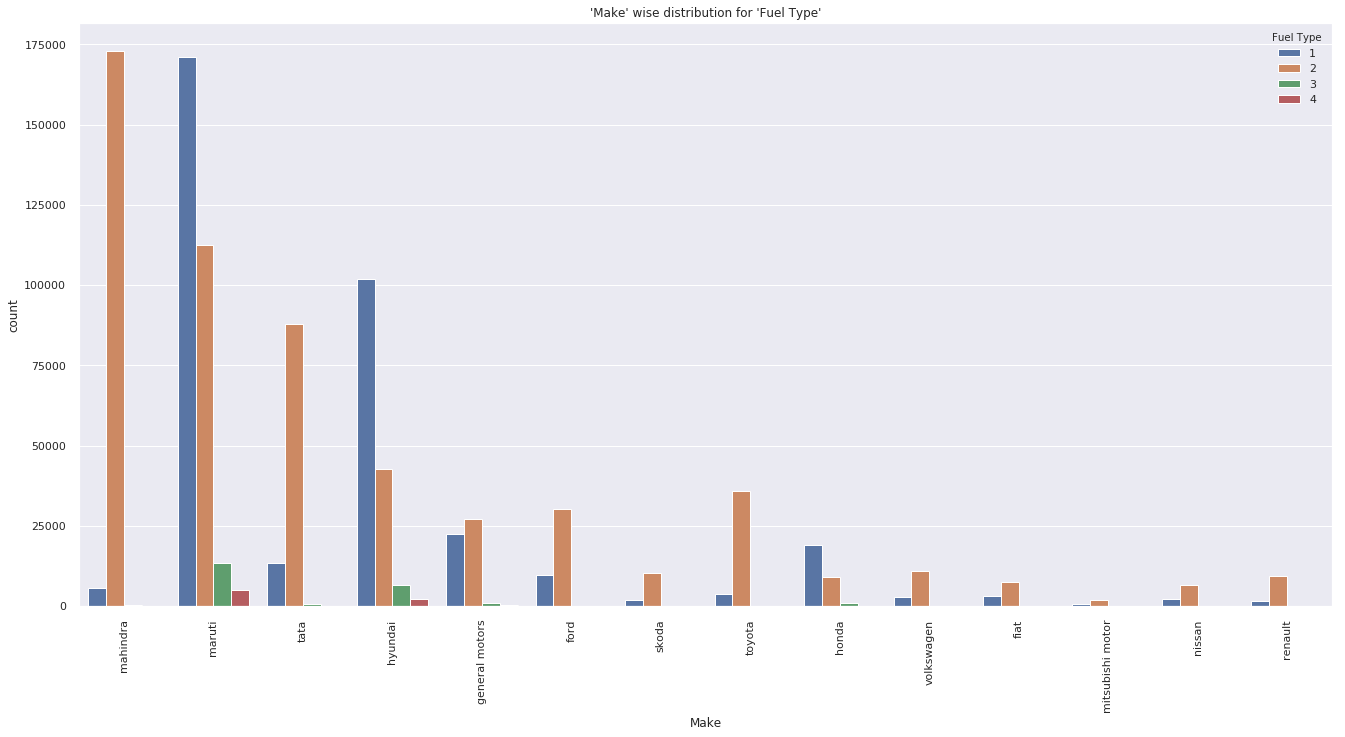

In [79]:
count_hue_plot(master_df,'Make','Fuel Type', 0.1)

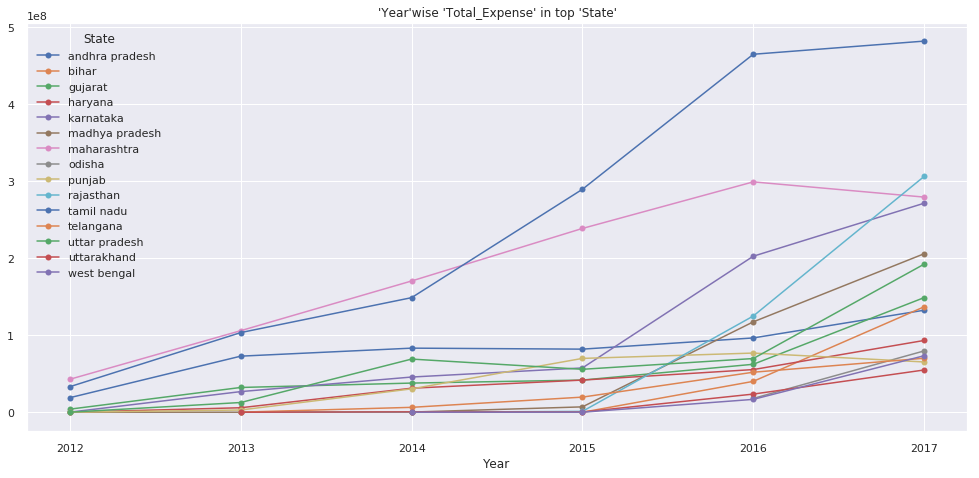

In [80]:
top_state_df, top_state = get_top_values(master_df, 'State',1)
plot_TimeSeries(top_state_df,'Year','State','Total_Expense')

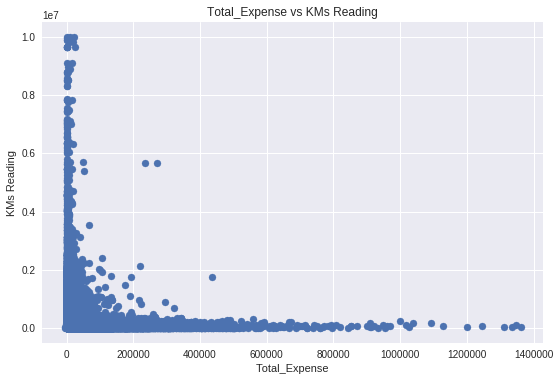

In [81]:
def scatter_plot(df,x,y):
    plt.style.use('seaborn')
    plt.scatter(df[x],df[y])
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title('{} vs {}'.format(x,y))
    plt.show()

scatter_plot(master_df,'Total_Expense','KMs Reading')

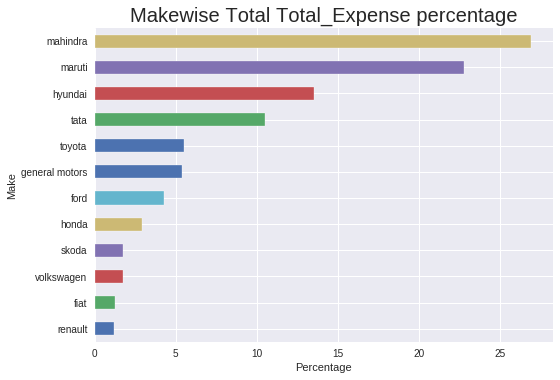

In [82]:
def plot_groupby(df,grpby_col, col):
    gp=df.groupby(grpby_col)[col].sum()
    gp=100*gp/sum(gp)
    gp=gp[gp>1]
    gp.sort_values().plot(kind='barh')
    plt.style.use('fivethirtyeight')
    plt.title('{}wise Total {} percentage'.format(grpby_col, col))
    plt.xlabel('Percentage')
    plt.tight_layout()

plot_groupby(master_df,'Make','Total_Expense')

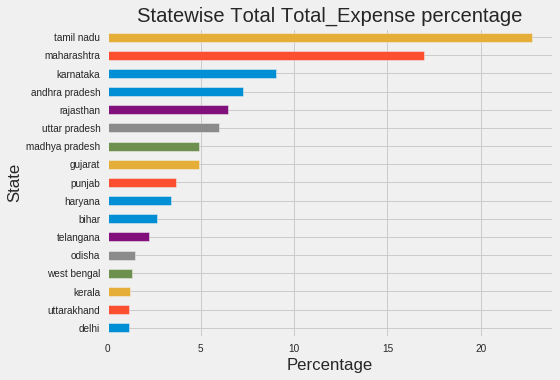

In [83]:
plot_groupby(master_df,'State','Total_Expense')

**Problem Statement-2**: Identify the type of order each state receives and present it
as an interactive visualization.

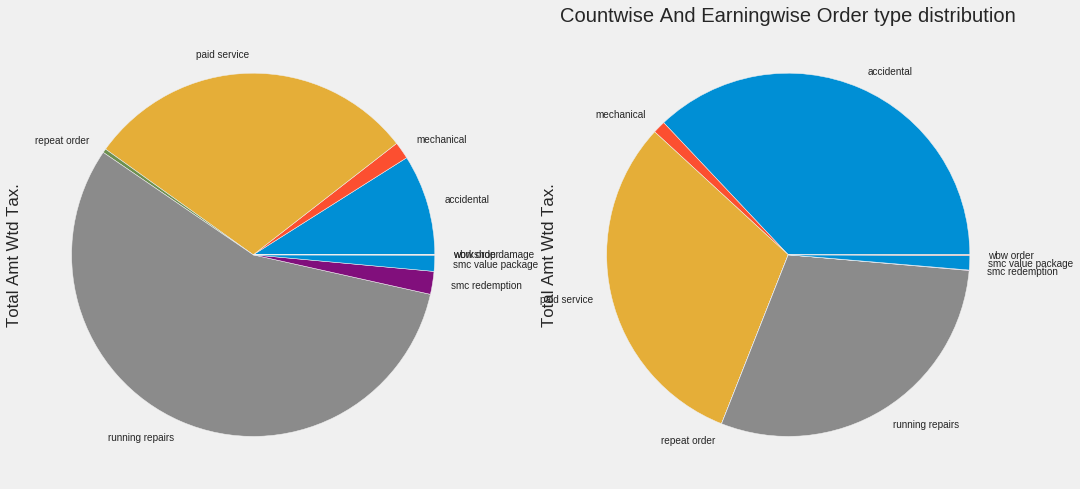

In [84]:
fig,ax = plt.subplots(1,2,figsize=(15,7))
plt.style.use('fivethirtyeight')
invoice_df.groupby('Order Type')['Total Amt Wtd Tax.'].count().plot(kind='pie',ax=ax[0])
invoice_df.groupby('Order Type')['Total Amt Wtd Tax.'].sum().plot(kind='pie',ax=ax[1])
plt.tight_layout()
plt.title('Countwise And Earningwise Order type distribution')
plt.show()

# Lifetime customer Value


In [85]:
# Lifetime customer Value

## customer expenditures per visit

s = (sum(invoice_df.groupby(['Customer No.'])["Total Amt Wtd Tax."].sum()))/502774

### number of visits per month (the “purchase cycle”)

from dateutil.relativedelta import relativedelta

from datetime import *
invoice_df['Invoice Date']=pd.to_datetime(invoice_df['Invoice Date'])
invoice_df['year']=invoice_df['Invoice Date'].dt.year
invoice_df['month']=invoice_df['Invoice Date'].dt.month

c = (invoice_df.groupby(['Customer No.'])["month"].count()).mode()

t = ((invoice_df.groupby(['Customer No.'])["Invoice Date"].max() - invoice_df.groupby(['Customer No.'])["Invoice Date"].min())/np.timedelta64(1,'M')).mean()

a = s * c

SLTV = (12 * a) * t

CLTV = t*12*s*c
CLTV

0    308022.219295
dtype: float64

In [86]:
from sklearn.cluster import KMeans
def Knumber(df):
      dist=[]
      # Iterate from 1-9
      for i in range(1,10):
            # Initialize KMeans algorithm
            km=KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
            # Fit on data
            km.fit(df)
            # Append WCSS to list storing WCSS
            dist.append(km.inertia_)
      # Initialize figure
      fig=plt.figure( figsize=[10,8])
      # Line plot # clusters on X-axis and WCSS on Y-axis 
      plt.plot(range(1,10),dist)
      plt.show()

In [87]:
master_df.isnull().sum().sum()

0

In [ ]:
df=invoice_df[['KMs Reading','Total Amt Wtd Tax.']]
Knumber(df)

In [ ]:
cluster=KMeans(n_clusters=4,init='k-means++',max_iter=300,n_init=10,random_state=0)
# create 'cluster' column
df['cluster']=cluster.fit_predict(df)
df.plot.scatter('KMs Reading','Total Amt Wtd Tax.', c='cluster', cmap='viridis')

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
df1=invoice_df[['Parts Total','Total Amt Wtd Tax.']]
Knumber(df1)

In [ ]:
cluster=KMeans(n_clusters=4,init='k-means++',max_iter=300,n_init=10,random_state=0)
# create 'cluster' column
df1['cluster']=cluster.fit_predict(df)
df1.plot.scatter('Parts Total','Total Amt Wtd Tax.', c='cluster', cmap='viridis')